In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

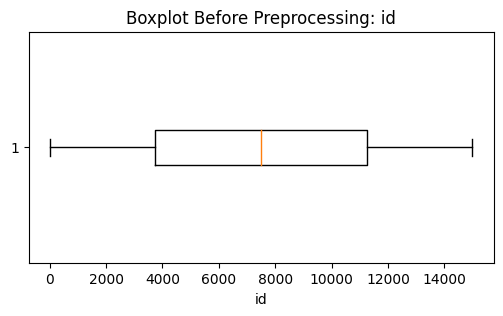

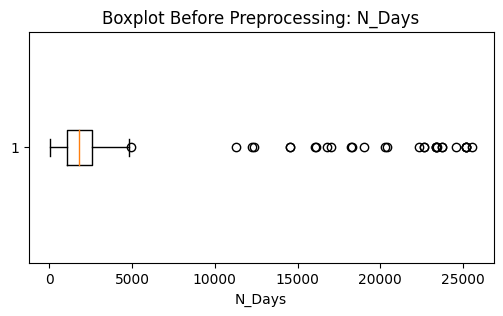

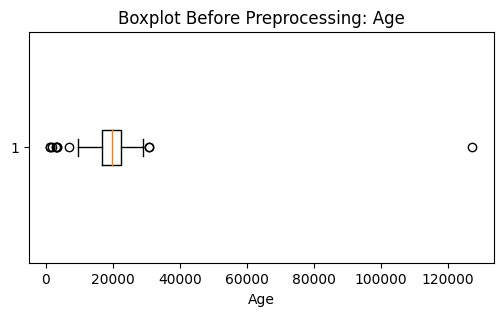

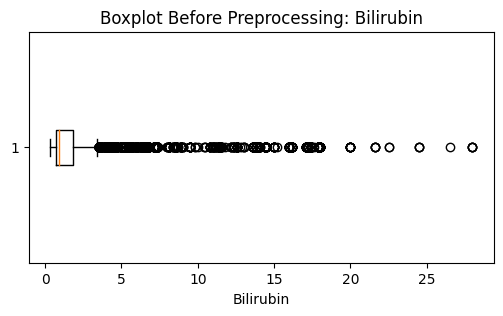

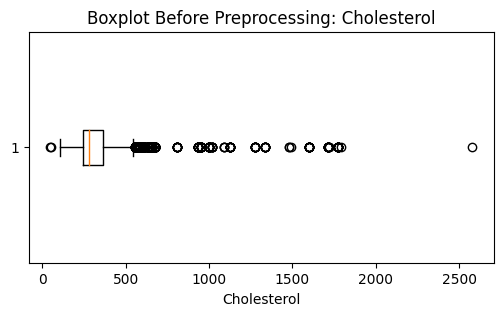

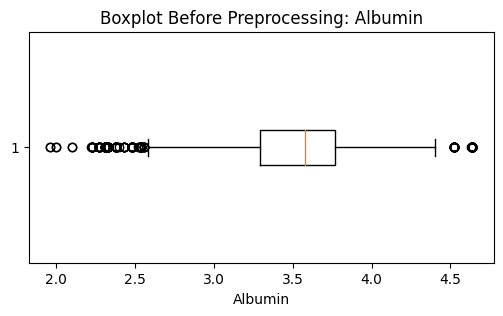

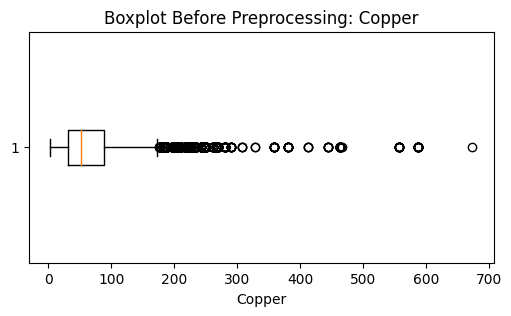

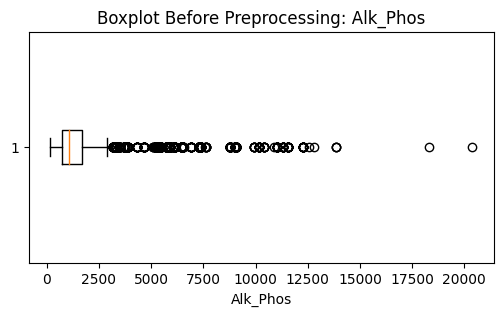

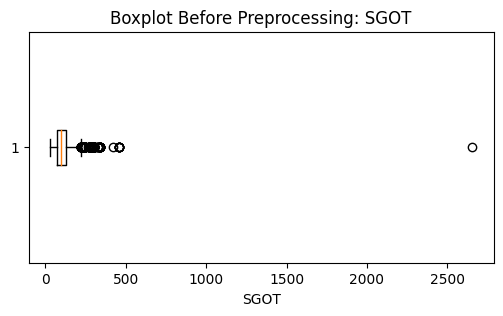

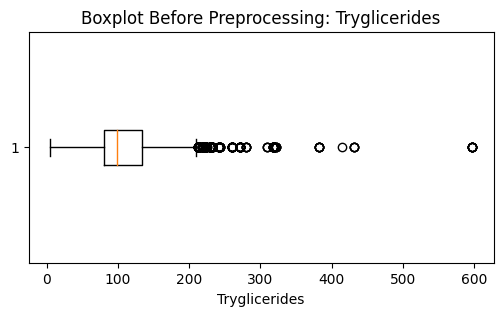

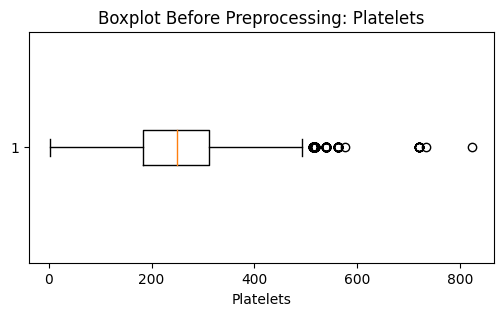

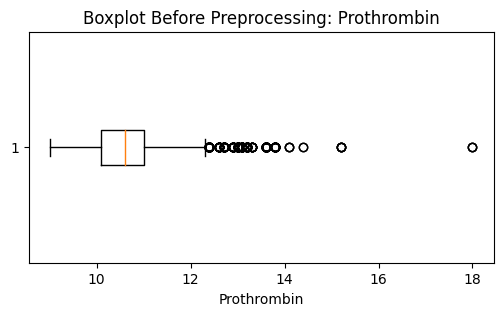

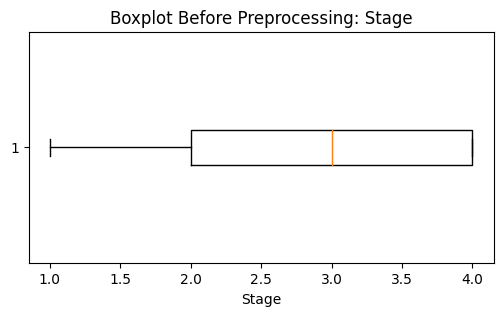

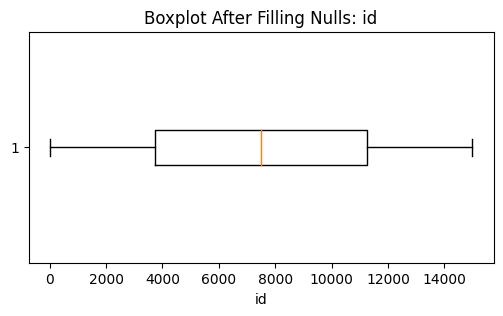

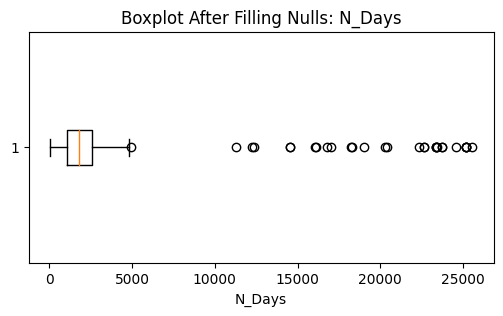

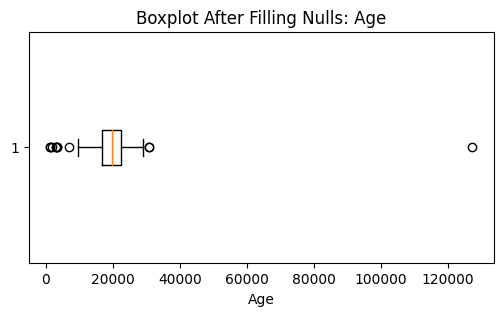

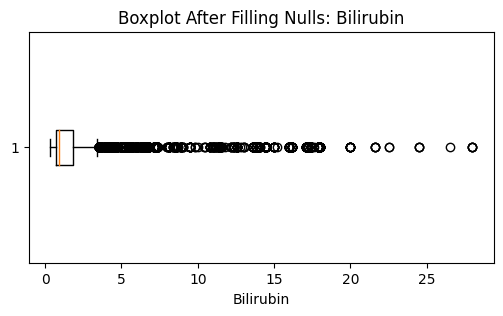

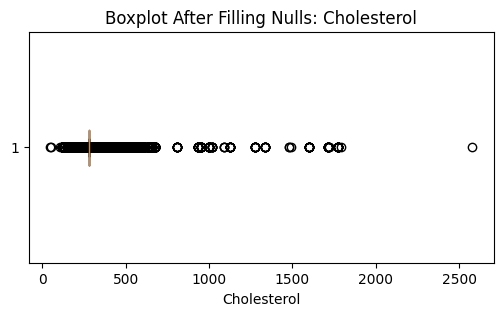

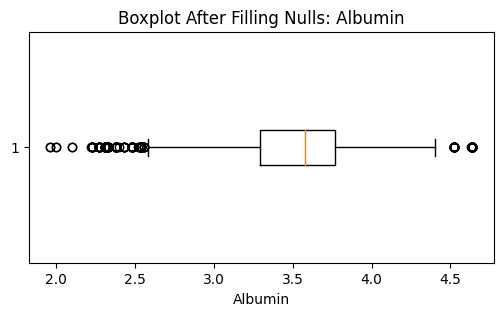

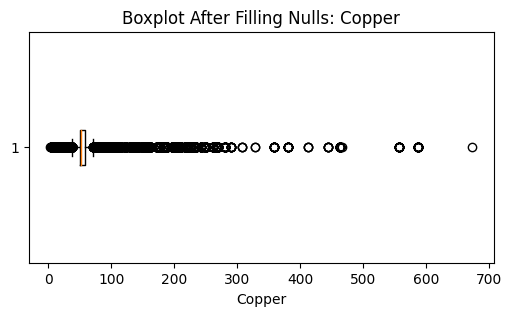

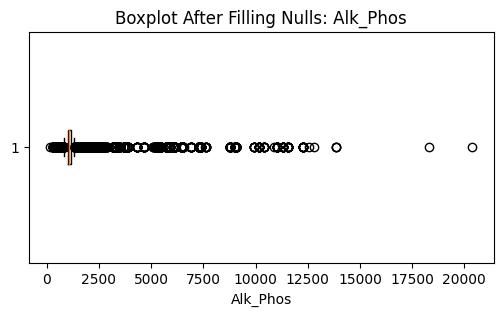

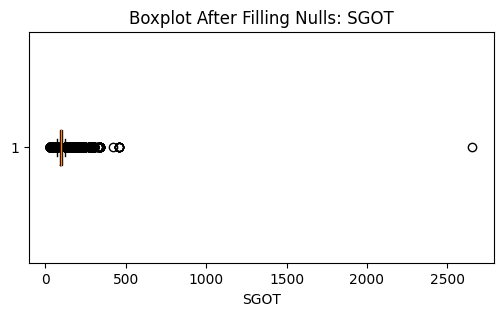

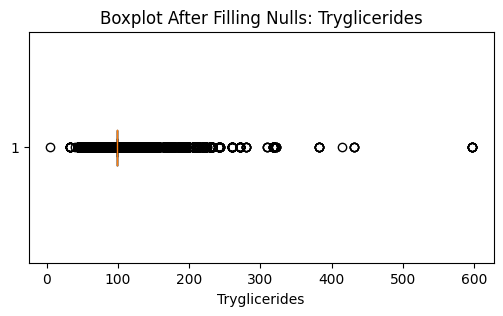

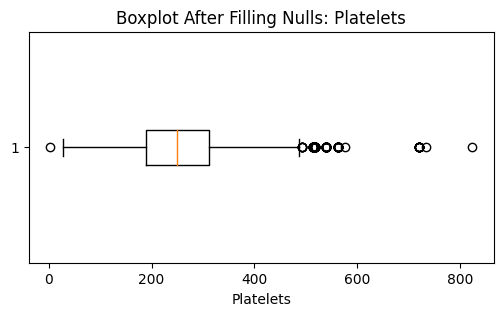

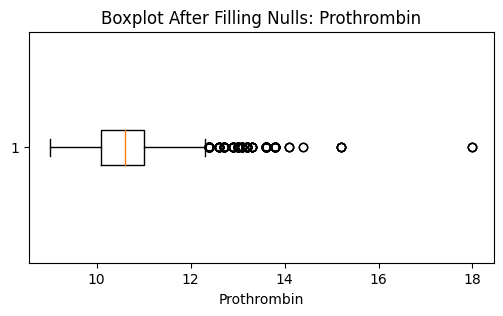

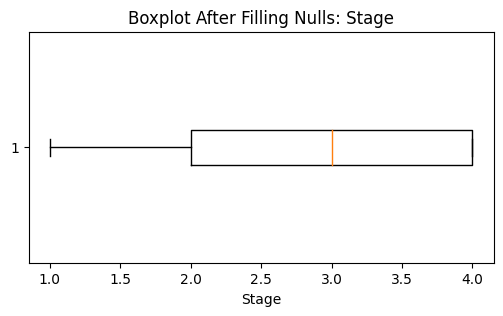

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.pipeline import Pipeline

# ==================== Load Data ====================
train = pd.read_csv("/kaggle/input/mock-test-2-mse-2/train.csv")
test = pd.read_csv("/kaggle/input/mock-test-2-mse-2/test.csv")

train.head()

# ==================== Separate Target ====================
y = train["Status"]
X = train.drop(columns=["Status"])

# ==================== Boxplots Before Preprocessing ====================
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    plt.boxplot(train[col].dropna(), vert=False)
    plt.title(f"Boxplot Before Preprocessing: {col}")
    plt.xlabel(col)
    plt.show()


# ==================== Handle Missing Values ====================
for col in X.columns:
    if X[col].dtype == 'object':  # categorical
        X[col] = X[col].fillna(X[col].mode()[0])
        test[col] = test[col].fillna(test[col].mode()[0])
    else:  # numeric
        X[col] = X[col].fillna(X[col].median())
        test[col] = test[col].fillna(test[col].median())

# # ==================== Label Encoding (before IsolationForest) ====================
# categorical_cols = X.select_dtypes(include=['object']).columns
# encoder = LabelEncoder()
# for col in categorical_cols:
#     X[col] = encoder.fit_transform(X[col])

# # ==================== Outlier Removal ====================
# iso = IsolationForest(contamination=0.03, random_state=42)
# outliers = iso.fit_predict(X)

# # Keep only non-outliers (1 means inliers, -1 means outliers)
# X = X[outliers == 1]
# y = y[outliers == 1]

# ==================== Train-Test Split ====================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==================== Preprocessing ====================
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# ==================== Boxplots After Preprocessing (Nulls Filled) ====================
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    plt.boxplot(X[col], vert=False)
    plt.title(f"Boxplot After Filling Nulls: {col}")
    plt.xlabel(col)
    plt.show()


# ==================== Build Pipeline ====================
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# ==================== Hyperparameter Tuning ====================
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_log_loss', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
model.fit(X_train,y_train)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# ==================== Validation Performance ====================
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, average='weighted'))
print("Recall:", recall_score(y_val, y_val_pred, average='weighted'))
print("F1 Score:", f1_score(y_val, y_val_pred, average='weighted'))
print("Log Loss:", log_loss(y_val, y_val_proba))

# ==================== Ensure same columns as training ====================
test_processed = test[X.columns]   # Align test with training features

# ==================== Predict for Submission ====================

test_proba = best_model.predict_proba(test_processed)

submission = pd.DataFrame({
    'id': test['id'],
    'Status_C': test_proba[:, list(best_model.classes_).index('C')],
    'Status_CL': test_proba[:, list(best_model.classes_).index('CL')],
    'Status_D': test_proba[:, list(best_model.classes_).index('D')]
})

submission.to_csv("Arshad.csv", index=False)
submission.head()

